# ACS2 in Maze Experiments
The following notebooks provides reproducible playground for experimenting how ACS2 agent behaves inside Maze environments.

## Checklist:
- check if classifiers with $q < 0.1$ are deleted,
- [ALP] - parameters update process,
- **Deletion of classifiers** - I think we are loosing good classifiers along the way
- ALP expected case
- ALP covering
- RL what is `maxP`

Butz notes:
- ACS2 should start with initially empty classifiers list (what does it mean)?
- e-greedy cannot be applied on the start with empty population,
- second learning should be triggered after successful step of finding reward?
- set_mark should mark the whole perception (probably not only changing parts) (unexpected case ACS2 p9)

TODO:
- set_mark copies whole perception (not indivudial points). But will it make any difference?

## My modifications
- behaviour policy strategies,
- dynamic exploration rate,
- offspring is not marked,

## Imports and configuration
Load project files from upper directory (nasty solution).

In [1]:
import sys
sys.path.append('/Users/khozzy/Projects/pyalcs')

Import `pyalcs` module

In [2]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

from alcs.agent.acs2 import ACS2
from alcs.environment.maze import Maze

# Exploration strategies
from alcs.strategies.ActionSelection import Random, ActionDelayBias, KnowledgeArrayBias

# Metrics
from alcs.helpers.metrics import \
    ActualStep,\
    ClassifierPopulationSize,\
    AveragedFitnessScore,\
    SuccessfulTrial,\
    AveragedConditionSpecificity,\
    AchievedKnowledge

Other helpers

In [3]:
%matplotlib inline

from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Experiment
We are going to test ACS2 **agent** inside **maze** environment. The agent will have 2 tasks:
1. learn the shortest path to the goal state,
2. learn the internal model of the environment

### Maze
Currently there are 4 mazes implemented:
- `mazes/MazeF1.maze` (deterministic),
- `mazes/MazeF2.maze` (deterministic),
- `mazes/MazeF3.maze` (deterministic),
- `mazes/MazeF4.maze` (non-deterministic)

Maze `MazeF4` introduces also the *aliasing* problem - the are two states that looks exactly the same for an agent.

In [4]:
# Location of the maze file
MAZE_LOCATION = 'mazes/Maze5.maze'

And visualize it

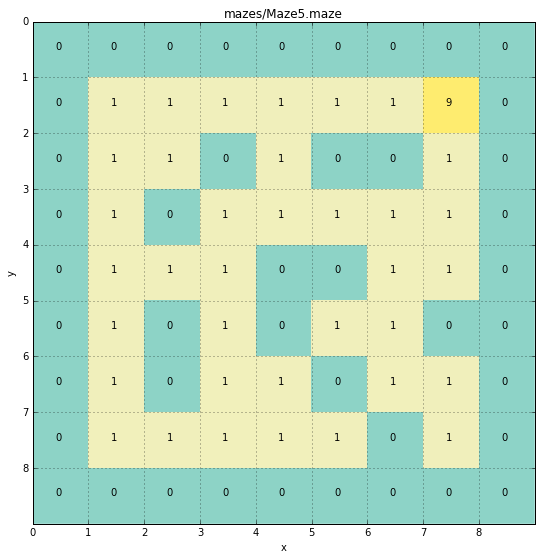

In [5]:
env = Maze(MAZE_LOCATION)

fig = plt.figure(figsize=(env.max_x, env.max_y))
ax = fig.add_subplot(111, aspect='equal')

# Render maze as image
plt.imshow(env.matrix, interpolation='none', cmap='Set3', aspect='auto',
           extent=[0, env.max_x, env.max_y, 0])

# Add labels to each cell
for x in range(0, env.max_x):
    for y in range(0, env.max_y):
        plt.text(x+0.4, y+0.5, env.matrix[y][x])

ax.set_title(MAZE_LOCATION)
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.xlim(0, env.max_x)
plt.ylim(env.max_y, 0)

plt.xticks(range(0, env.max_x))
plt.yticks(range(0, env.max_y))

plt.grid(True)
plt.show()

**Legend / reward map**:
- `0` is a $wall$ (cannot cross),
- `1` is a $path$ (reward $\rho = 0$),
- `9` is a $price$ (reward $\rho = 1000$)

### Agent
Agent interacts autonomously with the environment.

In this notebook it moves in maze for the certain number of steps.

> **Trial** is a successful run of agent when he manages to find the reward.

> After learning it should take him less and less steps to reach the goal.

At the beginning of each trial an agent is randomly placed inside the maze. He can perceive 4 values (neighbourhood cells - N, E, S, W) and move in 4 directions (N, E, S, W).

### Run the simulation
The whole simulation will run a certain number of times for certain number of steps.

In [6]:
# Number of experiments
EXPERIMENTS = 5

# Number of agent steps for each experiment
STEPS = 25000 # 10 000

# Maximum number of steps in single trial (before resetting an animat)
# Set to None for no limits
MAX_STEPS_IN_TRIAL = None

# Amount of processes pool
PROCESSES = 2

# Exploration strategy
# Available Greedy(), ActionDelayBias(), KnowledgeArrayBias()
EPSILON = 0.5
EXPLORATION_STRATEGY = KnowledgeArrayBias()

Let's declare a function performing a single experiment.

We are:
1. initializing an agent,
2. instructing him to collect specified measurements,
3. initializing the environment,
4. running the simulation,
5. returning obtained classifiers and metrics


In [ ]:
def perform_experiment(experiment):
    # Initialize the agent
    agent = ACS2(
        epsilon=EPSILON,
        strategy=EXPLORATION_STRATEGY
    )
    
    agent.add_metrics_handlers([
        ActualStep('time'),
        SuccessfulTrial('found_reward'),
        ClassifierPopulationSize('total_classifiers'),
        AveragedFitnessScore('average_fitness'),
        AveragedConditionSpecificity('average_specificity'),
        AchievedKnowledge('achieved_knowledge')
    ])

    # Initialize the environment
    env = Maze(MAZE_LOCATION)

    # Evaluate algorithm
    classifiers, metrics = agent.evaluate(env, STEPS, MAX_STEPS_IN_TRIAL)

    # Add information about the experiment into metrics
    metrics['experiment_id'] = [experiment] * len(metrics['time'])

    return classifiers, metrics

Then firing many jobs in parallel.

In [ ]:
all_classifiers = []
all_metrics = pd.DataFrame()

with ProcessPoolExecutor(PROCESSES) as executor:
    futures = []

    for i in range(EXPERIMENTS):
        future = executor.submit(perform_experiment, i)
        futures.append(future)

    for idx, el in enumerate(as_completed(futures)):
        classifiers, metrics = el.result()

        all_classifiers.append(classifiers)
        all_metrics = all_metrics.append(pd.DataFrame(metrics))

We can also inspect how the classifier population looks. Internal model of the environment is specified only by reliable classifiers.

In [ ]:
## take classifiers from the first experiment
classifiers = all_classifiers[0]

# Select only 'reliable' ones
reliable = [c for c in classifiers if c.is_reliable()]
reliable.sort(key=lambda cls: cls.action)

print("Population classifiers: {}".format(len(classifiers)))
print("Reliable classifiers: {}\n".format(len(reliable)))

for cls in reliable:
    print(cls)

<p style="color:red">**TODO**: There are duplicate classifiers!!!! Maybe subsumption does not works. Why low quality classifiers are not removed?</p>

## Performance metrics
Let's have a look how the performance metrics look like by taking 5 random samples:

In [ ]:
all_metrics.sample(5)

### Number of steps to food
Measures if the classifier actually *learns* something along the time.

> **Number of steps to food** - How many steps were needed in **each trial** to found the reward.

We need to have a little helper function for operating on obtained measurements.

In [ ]:
def get_avg_number_of_steps_to_food(performance):
    trials_by_experiment = pd.DataFrame(performance
                                        .groupby('experiment_id')
                                        .apply(lambda x: x['found_reward'].cumsum())
                                        .stack())
    trials_by_experiment.reset_index(inplace=True)
    trials_by_experiment.rename(columns = {'found_reward': 'time', 0: 'trial'},
                                inplace=True)

    # Experiment_id, trial, steps
    steps_per_trial_in_experiment = pd.DataFrame(trials_by_experiment
                                                 .groupby(['experiment_id', 'trial'])
                                                 .size())
    steps_per_trial_in_experiment.reset_index(inplace=True)
    steps_per_trial_in_experiment.rename(columns = {0: 'steps'}, inplace=True)

    # Trial, averaged steps
    averaged_steps_per_trial = pd.DataFrame(steps_per_trial_in_experiment.groupby('trial')['steps'].mean())
    averaged_steps_per_trial.rename(columns = {'steps': 'averaged_steps'}, inplace=True)
    averaged_steps_per_trial.reset_index(inplace=True)
    
    return averaged_steps_per_trial

Now we can visualize the results

In [ ]:
steps_to_food = get_avg_number_of_steps_to_food(all_metrics)[:80]
steps_to_food['MA'] = steps_to_food['averaged_steps'].rolling(window=50).mean()

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.bar(steps_to_food['trial'], steps_to_food['averaged_steps'])
plt.plot(steps_to_food['trial'], steps_to_food['MA'], 'r', linewidth=2.0)

plt.title('Averaged number of steps to food')
plt.xlabel('Trial')
plt.ylabel('Steps')

#plt.yscale('log')
plt.grid(True)

plt.show()

### Achieved knowledge
Measures if an agent is *learning* the environment.

> **Achieved knowledge** - test whether or not there is a **reliable classifier** for each transition $(\sigma_{1}, \alpha, \sigma_{2})$ with $\sigma_{1} \neq \sigma_{2}$ that can be applied in $\sigma_{1}$ and anticipates $\sigma_{2}$ correctly.

This metric is calculated after each time-step done by the agent.

In [ ]:
def get_avg_achieved_knowledge_per_step(performance):
    knowledge_per_step = pd.DataFrame(performance.groupby('time')['achieved_knowledge'].mean())
    knowledge_per_step.reset_index(inplace=True)
    return knowledge_per_step

Plot the results

In [ ]:
knowledge_per_step = get_avg_achieved_knowledge_per_step(all_metrics)
knowledge_per_step['MA'] = knowledge_per_step['achieved_knowledge'].rolling(window=500).mean()

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(knowledge_per_step['time'], knowledge_per_step['achieved_knowledge'], 'b')
plt.plot(knowledge_per_step['time'], knowledge_per_step['MA'], 'r', linewidth=2.0)

plt.title('Averaged achieved knowledge')
plt.xlabel('Step')
plt.ylabel('Achieved knowledge')

plt.grid(True)

plt.show()

### Specificity measure
Measure the *generalization* in classifier population.

> **Specificity measure** - Equal to the **sum** of all specialized attributed in condition part of all classifiers in population **divided** by the number of classifiers **times** the length of  the perception $\sigma$.

You can read more about this metric in "*Introducing a Genetic Generalization Pressure to the
Anticipatory Classfierier System - Part2: Performance Analysis*" by Martin V. Butz.

Plot should change after modifing the agent's *mutation* and *cross over* values. The author claims that the best generalization was reached for mutation rate $\mu = 0.4$.

In [ ]:
def get_avg_specificity_per_step(performance):
    spec_per_step = pd.DataFrame(performance.groupby('time')['average_specificity'].mean())
    spec_per_step.reset_index(inplace=True)
    return spec_per_step

Plot the results

In [ ]:
spec_per_step = get_avg_specificity_per_step(all_metrics)

fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(spec_per_step['time'], spec_per_step['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity of condition parts for classifiers')
plt.xlabel('Step')
plt.ylabel('Specificity')

plt.grid(True)

plt.show()

We can observe that the value stabilizes near 0.45 which means most elements of condition part is wildcards.

We can execute another experiment, but this time also the mutation ratio will change.

The following image presents how the alternative plot can look like:
![title](temp/generalization.png)

Prepare variables for the simulation

In [ ]:
# Create an array containing possible values of mutation rate
mutation_rates = np.linspace(0, 1, 9)

# Number of experiments
EXPERIMENTS = 10

# Number of steps in each experiment
STEPS = 10000

Run the simulation

In [ ]:
performance = pd.DataFrame()

for experiment in range(EXPERIMENTS):
    print("Experiment: [{}]".format(experiment))
    
    for mutation_rate in mutation_rates:
        print("\tMutation rate: {}".format(mutation_rate))
        
        # Re-initialize the environment
        env = Maze(MAZE_LOCATION)

        # Initialize the agent with metric handler
        agent = ACS2(mu=mutation_rate)
        agent.add_metrics_handlers([
            ActualStep('time'),
            AveragedConditionSpecificity('average_specificity'),
        ])
        
        # Evaluate algorithm
        #classifiers, metrics = agent.evaluate(env, STEPS)

        # Add information about the experiment into metrics
        metrics['experiment_id'] = [experiment] * len(metrics['time'])
        metrics['mutation_rate'] = [mutation_rate] * len(metrics['time'])

        # Append performance metrics
        performance = performance.append(pd.DataFrame(metrics))

To calculate the condition specificity we will take it's value obtained after last step in each experiment and average it.

In [ ]:
def get_avg_specificity_by_mutation_rate(performance):
    last_as_by_experiment = pd.DataFrame(performance
                                         .groupby(['experiment_id','mutation_rate'])['average_specificity']
                                         .last())
    last_as_by_experiment.reset_index(inplace=True)
    
    avg_as_by_mutation_rate = pd.DataFrame(last_as_by_experiment
                                           .groupby(['mutation_rate'])['average_specificity']
                                           .mean())
    avg_as_by_mutation_rate.reset_index(inplace=True)
    
    return avg_as_by_mutation_rate

See how the results look like

In [ ]:
avg_as_by_mutation_rate = get_avg_specificity_by_mutation_rate(performance)
avg_as_by_mutation_rate

In [ ]:
fig = plt.figure(figsize=(15, 8), dpi=100)

plt.plot(avg_as_by_mutation_rate['mutation_rate'],
         avg_as_by_mutation_rate['average_specificity'], 'r', linewidth=2)
plt.title('Averaged specificity ratio')
plt.xlabel('Mutation rate')
plt.ylabel('Specificity')

plt.grid(True)
plt.show()